<a href="https://colab.research.google.com/github/Achillesy/Thrombolysis_DeepTICI/blob/main/predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DeepTICI
---
This repository  is a fork of <https://github.com/IPMI-ICNS-UKE/DeepTICI>.
Thanks to STROKE [publication](https://doi.org/10.1161/STROKEAHA.120.033807) for sharing the official code and model weights.

The following code follows the license rights and limitations of the original shared code (CC BY-NC 4.0). You can view the full license text here:
<https://raw.githubusercontent.com/IPMI-ICNS-UKE/DeepTICI/main/LICENSE.txt>


**This code is provided for research and educational purposes only. Please do not use it for commercial purposes.**

If you have any questions, please contact me at: xuchu_liu@rush.edu

## Requirements

In [ ]:
!pip install efficientnet_pytorch
!pip install SimpleITK
!pip install pydicom

## Installation

### Helper

In [ ]:
from enum import Enum, auto

"""implements output and model modes to prevent using strings"""


class OutputMode(Enum):
    last_frame = auto()
    all_frames = auto()


class ModelMode(Enum):
    train = auto()
    inference = auto()


### DataLoader

In [ ]:
import os
from abc import ABC
from typing import List, Tuple, Union, Literal

import SimpleITK as sitk
import cv2
import numpy as np
import torch
from skimage.filters import threshold_multiotsu


class BaseDataProcessor(ABC):

    def __init__(self):
        """initializes a chain of preprocessor steps which is then executed for each elem"""
        self._chain = []

    def _chain_exe(self, image: np.ndarray) -> np.ndarray:
        """applies the preprocessor steps to an image, based on the order in the chain
            arg: image: nd array
            return: image as nd array"""
        for processor_step, kwargs in self._chain:
            if kwargs:
                image = processor_step(image, **kwargs)
            else:
                image = processor_step(image)
        return image.astype(np.float32)

    def add_processor_step(self, func_name: str, kwargs: dict):
        """appends preprocessor step from name and kwargs to the chain
        args:
            func_name: name of the preprocessor function
            kwargs: keyword arguments applied to the func_name together with nd image/array"""
        func = getattr(self, func_name)
        self._chain.append((func, kwargs))

    @classmethod
    def to_chain(cls, chain_elems: dict):
        """adds preprocesser functions to the chain with corresponding elements.
        chain_elems contains the functain name as a key and kwargs as values
        args:
            chain_elems: is a dictionary with the preprocessor function name as key and the coressponding kwargs as
            items. Items are a dict itself."""
        inst = cls()
        for chain_elem, elem_kwargs in chain_elems.items():
            inst.add_processor_step(chain_elem, elem_kwargs)
        return inst

    def __call__(self, image: np.ndarray, **kwargs):
        """executes chain"""
        return self._chain_exe(image)


class BasePreProcessor(BaseDataProcessor):
    """Implementation of Abstract Class BaseDataProcessor. Basic steps are implemented for preprocessing."""

    def __init__(self):
        super().__init__()

    """all functions take an nd.array as input and return a n.array"""

    @staticmethod
    def temp_normalize_image(image: np.ndarray) -> np.ndarray:
        """normalizes images by substracting the mean along temporal axis"""
        return image - np.mean(image, axis=0)

    @staticmethod
    def normalize_image_range(image: np.ndarray) -> np.ndarray:
        """scales image values to an intervall of -1 to 1"""
        return 2 * (image - image.min()) / (image.max() - image.min()) - 1

    @staticmethod
    def median_normalize_slice(image: np.ndarray) -> np.ndarray:
        """sets the image median to a value of 0"""
        return image - np.median(image, axis=(-2, -1), keepdims=True)

    @staticmethod
    def set_background_to_one(image: np.ndarray) -> np.ndarray:
        """sets background pixel value to one"""
        if image.sum() / np.prod(image.shape) < 0:
            image = image * -1
        return image


class PreProcessor(BasePreProcessor):
    """implements more specicfic PreProcessor steps, that take additional arguments"""

    @staticmethod
    def clip_image(image: np.ndarray, boundaries: Tuple[float, float] = None,
                   mode: Literal['multiotsu', 'median'] = None) -> np.ndarray:
        """clips image values to an intervall based on image intensieties.
        Availabe are multiotsu thresholding, and above median
        args:
            boundaries: image is clipped by those fixed values, must be in the format(min,max). If mode is given,
                        boundaries are ignored.
            mode: must be either mutlitotsu or median. If multiotsu boundraries are based on two thresholds. If median
                  the upper boundary is the median value and lower the min value of the image """

        if mode == 'multiotsu':
            boundaries = threshold_multiotsu(image, classes=3)
        elif mode == 'median':
            boundaries = [image.min(), None]
            boundaries[1] = np.median(image)
        elif not boundaries and not mode:
            boundaries = [image.min(), image.max()]
        return np.clip(image, boundaries[0], boundaries[-1])

    @staticmethod
    def resample_image(image: np.ndarray, frame_shape=(380, 380)) -> np.ndarray:
        """resamples image to specified pixel size using nearest neighbours
        args:
            frame_shape: crops the last two dimensions to the given value"""
        num_frames = len(image)
        resized_image = np.zeros((num_frames,) + frame_shape)
        for idx, frame in enumerate(image):
            resized_image[idx] = cv2.resize(frame, frame_shape, interpolation=cv2.INTER_NEAREST)
        return resized_image

    @staticmethod
    def crop_image(image: np.ndarray, tol=0.01) -> np.ndarray:
        """removes bars (with noise) on image edges. tol is the amount of noise allowed.
            args:
                tol: tolerance value above which axis are accepted to contain image information. If a whole row
                     contains no information and is at the image edge it is assumed to contain no value for
                     classifiation"""
        mask = np.std(image, axis=0) > tol
        idx = np.ix_(mask.any(1), mask.any(0))
        return image[:, idx[0], idx[1]]

    @staticmethod
    def center_crop(image, rel_size=(0.5, 0.5)) -> np.ndarray:
        """takes the center crop of a given image. rel_size is the relative size of the center crop in realtion to the
         input image
         args:
            rel_size: relative size of the center crop in respect to the orginal image. """
        x_size, y_size = image.shape[-2:]
        pos_x_1 = int(x_size * (1 - rel_size[0]) / 2)
        pos_y_1 = int(y_size * (1 - rel_size[1]) / 2)
        pos_x_2 = int(pos_x_1 + x_size * rel_size[0])
        pos_y_2 = int(pos_y_1 + y_size * rel_size[1])
        image = image[..., pos_x_1:pos_x_2, pos_y_1:pos_y_2]
        return image


class DataLoader:
    def __init__(self, preprocessor_steps: dict):
        """class to load dicom images from path, gets preprocessor arguments to build the preprocessor
        args:
            preprocessor_steps: dict containing names and kwargs of the preprocessing steps"""
        self.preprocessor = PreProcessor.to_chain(preprocessor_steps)

    def __call__(self, series_paths: List[Union[str, os.PathLike]]) -> Tuple[torch.Tensor, torch.Tensor]:
        """loads images to the RAM and applies the preprocessor steps
        args:
            series_paths: List of paths. First entry must point to AP and second to the lateral view. Views must be the
                          same the length.
            return: A tuple containing, two tensors 1.) both views shape: 1 (dummy batch) x time x 2 (views) x height x
                    width 2.) length of the series """

        # loads both dicom views
        series = [self._load_image(path) for path in series_paths]
        series_lengths = [len(view) for view in series]
        assert len(series_lengths) == 2, f'expected 2 views, got {len(series_lengths)} views'
        assert series_lengths[0] == series_lengths[1], f'Length of DSA views are not equal'

        # converts views to array and make a 3Ch image. The 3Ch are filled with consecutive frames
        series = np.array(series)
        series = self._make_3_ch_img(series)
        series = torch.tensor(series, dtype=torch.float32).unsqueeze(dim=0)
        return series, torch.tensor(series_lengths[0]).unsqueeze(dim=0)

    @staticmethod
    def _make_3_ch_img(img: np.ndarray) -> np.ndarray:
        """creates a 3Ch image from a 1Ch image. The 3Ch consists of 3 consecutive frames, centered around the original
        Frame
        arg:
            img: 1CH Image
        return: same image with 3CH. Each slice from the orginal image is converted to the center channel sourounded by
                the previous and nect slice."""
        new_img = np.zeros((*img.shape[0:2], 3, *img.shape[-2:])).swapaxes(1, 0)
        for i_frame in range(len(new_img)):
            img_temp = np.zeros(new_img.shape[1:])
            for i_channel in range(img_temp.shape[1]):
                if i_frame == 0 and i_channel == 0:
                    pass
                elif i_frame == len(new_img) - 1 and i_channel == 2:
                    pass
                else:
                    img_temp[:, i_channel] = img[:, i_frame - 1 + i_channel]
            new_img[i_frame] = img_temp
        return new_img

    def _load_image(self, image_path: Union[str, os.PathLike]) -> np.ndarray:
        """loads dicom images to RAM and preprocesses image from path
            args:
                image_paths: list containing path to two views order: [ap, lat]
            return: preprocessed dicom image as np.array"""
        image = self._load_img_to_ram(image_path)
        image = self.preprocessor(image)
        return image.astype(np.half)

    @staticmethod
    def _load_img_to_ram(file_path: Union[str, os.PathLike]) -> np.ndarray:
        """loads dicom image to RAM
            args:
                image_path: path pointing to an dicom image
            return: dicom image as np.array"""
        assert file_path.endswith('.dcm'), 'only Dicom file format is supported'
        image = sitk.GetArrayFromImage(sitk.ReadImage(file_path))
        return image


### Model

In [ ]:
import math
import os
from typing import Union, List

import torch
import torch.nn as nn
import torch.nn.functional as F
from efficientnet_pytorch import EfficientNet
from torch.cuda.amp import autocast

class SwishImplementation(torch.autograd.Function):
    """legacy method used before torch.nn.SiLU was available"""

    @staticmethod
    def forward(ctx, i):
        result = i * torch.sigmoid(i)
        ctx.save_for_backward(i)
        return result

    @staticmethod
    def backward(ctx, grad_output):
        i = ctx.saved_tensors[0]
        sigmoid_i = torch.sigmoid(i)
        return grad_output * (sigmoid_i * (1 + i * (1 - sigmoid_i)))


class Swish(nn.Module):
    """pytorch implementation of Swish activation function"""

    def forward(self, x):
        return SwishImplementation.apply(x)


class EfficientTwoArmEncoder(nn.Module):
    """Implements a two-arm-encoder network based on an efficient-net b0 backbone. This networks fuses each frame of two
     views to one latent representation by combining them before the last convolutional layer."""

    def __init__(self, num_classes: int = 7, in_channels: int = 3, feature_size: int = 1280):
        """args:
            num_classes: Number of classes if this network is used for classification.
            in_channels: Number of channels in the input image
            feature_size: size of the latent space"""
        super().__init__()
        # Efficient-net backbone
        self.feature_extractor = EfficientNet.from_pretrained('efficientnet-b0', num_classes=num_classes,
                                                              in_channels=in_channels)
        self.swish = Swish()

        # combines latent representation of the two views
        self.combine_layer = nn.Sequential(
            nn.Conv2d(320 * 2, feature_size, 1, bias=False),
            nn.BatchNorm2d(feature_size, momentum=0.01, eps=1e-3),
            self.swish
        )

        # classification layer
        self.final_layer = nn.Sequential(
            nn.Linear(feature_size, num_classes),
            Swish(),
            nn.Softmax(dim=-1)
        )

    def forward(self, x: torch.Tensor, *args, **kwargs) -> torch.Tensor:
        """args:
            x: Tensor of size batch_size x 2 (num_views) x frames x channels x height x width
            returns: latent representation of x batch_size x frames x feature_size"""

        x_shape = x.shape
        # flatten image to batch_size*views*frames x channels x height x width
        x = x.contiguous().view((-1, *x_shape[-3:]))

        # encode all frames and views simultaneously
        x = self.extract_features(x)

        # unflatten to dimension: batch_size*frames x channels*views x height x width
        x = x.view((-1, x.shape[-3] * 2, *x.shape[-2:]))
        x = self.combine_layer(x)
        x = F.adaptive_avg_pool2d(x, 1)
        x = x.squeeze(dim=2).squeeze(dim=2)

        # reshape to batch_size x frames x feature_size
        x = x.view((*x_shape[:2], x.shape[-1]))
        return x

    def extract_features(self, x: torch.Tensor) -> torch.Tensor:
        """applies all layers of efficient-net b0 until the last convolution
        args:
            x: input tensor shape: n x channels x height x width"""
        x = self.swish(self.feature_extractor._bn0(self.feature_extractor._conv_stem(x)))
        for idx, block in enumerate(self.feature_extractor._blocks):
            drop_connect_rate = self.feature_extractor._global_params.drop_connect_rate
            if drop_connect_rate:
                drop_connect_rate *= float(idx) / len(self.feature_extractor._blocks)
            x = block(x, drop_connect_rate=drop_connect_rate)
        return x


class FastGRU(nn.Module):
    def __init__(self, feature_size: int, output_size: int = None):
        """intializes weights of the GRU with three gates: Input, forget and hidden.
        args:
            feature_size: Size of the input in the last dimension
            output_size: size of the cell state/ output. if not given it is equal to feature_size"""
        super().__init__()
        self.input_size = feature_size
        if not output_size:
            self.hidden_size = self.input_size
        else:
            self.hidden_size = output_size
        self.W = nn.Parameter(torch.Tensor(self.input_size, self.hidden_size * 3))
        self.U = nn.Parameter(torch.Tensor(self.hidden_size, self.hidden_size * 3))
        self.bias = nn.Parameter(torch.Tensor(self.hidden_size * 3))
        self.init_weights()

    def init_weights(self):
        stdv = 1.0 / math.sqrt(self.hidden_size)
        for weight in self.parameters():
            weight.data.uniform_(-stdv, stdv)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """implements GRU forward pass with three gates. Input, forget and output. The input gate controls the relevance
         of new timesteps, the forget gate the relevance of the cell state in regard to the new input and the output
         gate controls the new cellstate.
         args:
            x: input tensor of shape batch x timesteps x feature_size"""
        bs, seq_sz, _ = x.size()
        hidden_seq = []
        dropout_prob = 0.1
        h_t, c_t = (torch.zeros(bs, self.hidden_size).to(x.device),
                    torch.zeros(bs, self.hidden_size).to(x.device))

        x = F.dropout(input=x, p=dropout_prob, training=self.training)

        for t in range(seq_sz):
            x_t = x[:, t, :]

            gates = x_t @ self.U + c_t @ self.W + self.bias

            z_t, r_t = (
                # input
                torch.sigmoid(gates[:, :self.hidden_size]),
                # forget
                torch.sigmoid(gates[:, self.hidden_size:self.hidden_size * 2])
            )

            x_t = torch.tanh(r_t * x_t @ self.U + c_t @ self.W + self.bias)[:,
                  self.hidden_size * 2:self.hidden_size * 3]

            c_t = (1 - z_t) * c_t + x_t

            hidden_seq.append(c_t.unsqueeze(0))

            c_t = F.dropout(input=c_t, p=dropout_prob, training=self.training)

        hidden_seq = torch.cat(hidden_seq, dim=0)
        # reshape from shape (sequence, batch, feature) to (batch, sequence, feature)
        hidden_seq = hidden_seq.transpose(0, 1).contiguous()

        return hidden_seq


class TICIModelHandler(nn.Module):
    def __init__(self,
                 num_classes: int,
                 feature_size: int,
                 pretrained: Union[None, Union[str, os.PathLike], List[Union[str, os.PathLike]]] = None,
                 in_channels: int = 3,
                 output_size: int = None
                 ):
        """Wrapper around Encoder+GRU+Classifier structure. Serves model loading and selecting the right timesteps for
        training and inference.
        args:
            num_classes: number of classes in the output
            feature_size: output size of the encoder network
            pretrained: path(s) to pickeld weights, if multiple paths are given an ensamble is applied
            in_channels: expected number of channels in the input image
            output_size: size of the cell state for the GRU. If not given equal to feature_size"""
        super().__init__()
        self.num_classes = num_classes
        self.network = TICITemporalNetwork(in_channels=in_channels, feature_size=feature_size, output_size=output_size,
                                           num_classes=num_classes)
        self.pretrained = False
        if pretrained:
            if isinstance(pretrained, list):
                self.pretrained = pretrained
            else:
                # if multiple paths ensemble over all given weights
                self.pretrained = True
                self.load_model(pretrained)

    def load_model(self, path):
        """load state dict of the network.
        args:
            path: path to weights"""
        state_dict = torch.load(path)
        while any(['module.' in k for k in state_dict.keys()]):
            # remove eventual pytorch wrapper
            state_dict = {k.replace('module.', ''): v for k, v in state_dict.items()}
        self.load_state_dict(state_dict, strict=False)

    @autocast()
    def forward(self, x: torch.Tensor, series_length: torch.Tensor = None, model_mode: ModelMode = ModelMode.inference,
                output_mode: OutputMode = OutputMode.last_frame) -> torch.tensor:
        if x.dim() == 5:
            x = x.unsqueeze(dim=0)
        assert x.dim() == 6, 'Input must be 4 or 5 dimensional ((batch) x time x view x channels x height x width'
        if series_length:
            if series_length.dim() == 0:
                series_length = series_length.unsqueeze(dim=0)

        series_length = series_length.to(x.device)
        assert isinstance(model_mode, ModelMode), 'forward pass mode is not implemented (yet)'

        # inference
        if model_mode == ModelMode.inference:
            with torch.no_grad():
                # ensemble
                if isinstance(self.pretrained, list):
                    for path in self.pretrained:
                        self.load_model(path)
                        self.eval()
                        try:
                            predictions += self.network(x)
                        except NameError:
                            predictions = self.network(x)
                    predictions /= len(self.pretrained)
                else:
                    self.eval()
                    predictions = self.network(x)
        # training
        elif model_mode == ModelMode.train:
            self.train()
            predictions = self.network(x)
        else:
            raise NotImplementedError('forward pass mode is not implemented (yet)')

        assert isinstance(output_mode, OutputMode), 'output mode is not implemented (yet)'
        if output_mode == OutputMode.last_frame:
            predictions = self._get_last_frame_in_batch(predictions, series_length)
        elif output_mode == OutputMode.all_frames:
            pass

        return predictions

    @staticmethod
    def _get_last_frame_in_batch(predictions: torch.Tensor, series_length: torch.Tensor = None) -> torch.Tensor:
        """iterates through batch to fetch the last frame of each input
        args:
            predictions: tensor of shape batch x time x num_classes
            series_length: tensor containing the series lengths of batch elements. If not specified the last frame is
            considered"""
        if not series_length:
            pred = predictions[:, -1]
        else:
            pred = torch.zeros((predictions.shape[0], predictions.shape[-1]), device=predictions.device)
            for i, _series_length in enumerate(series_length):
                pred[i] = predictions[i, _series_length - 1]
        return pred


class TICITemporalNetwork(nn.Module):
    def __init__(self,
                 in_channels: int,
                 output_size: int,
                 num_classes: int,
                 feature_size: int) -> torch.Tensor:
        """Wraps around encoder, GRU and classifier.
        args:
            in_channels: number of channels in input
            output_size: size of the GRUs cell state
            num_classes: number of classes in the dataset
            feature_size: number of features from the encoder"""
        super().__init__()
        self.encoder = EfficientTwoArmEncoder(feature_size=feature_size, in_channels=in_channels,
                                              num_classes=num_classes)
        self.gru = FastGRU(feature_size=feature_size, output_size=output_size)
        self.classifier = nn.Sequential(nn.Dropout(),
                                        nn.Linear(feature_size, num_classes),
                                        Swish(),
                                        nn.Softmax(dim=-1))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """forward pass through all model parts:
        args:
            x: input tensor of shape batch x time x views x channels x height x width"""
        x = self.encoder(x, mode='encoder')
        x = self.gru(x)
        x = self.classifier(x)
        return x


## Preprocess

### Load DSA series pipeline

In [ ]:
preprocessor_steps = {
    'crop_image': {'tol': 0.01},
    'clip_image': {'mode': 'multiotsu'},
    'temp_normalize_image': None,
    'normalize_image_range': None,
    'resample_image': {
        'frame_shape': (224, 224)
    }
}
data_loader = DataLoader(preprocessor_steps)

### Load model weights

In [ ]:
!wget https://github.com/IPMI-ICNS-UKE/DeepTICI/raw/main/model_weights/experiment_I

--2023-12-15 15:21:53--  https://github.com/IPMI-ICNS-UKE/DeepTICI/raw/main/model_weights/experiment_I
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/IPMI-ICNS-UKE/DeepTICI/main/model_weights/experiment_I [following]
--2023-12-15 15:21:53--  https://raw.githubusercontent.com/IPMI-ICNS-UKE/DeepTICI/main/model_weights/experiment_I
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 59091797 (56M) [application/octet-stream]
Saving to: ‘experiment_I.1’

experiment_I.1      100%[===================>]  56.35M  --.-KB/s    in 0.1s    

2023-12-15 15:21:53 (413 MB/s) - ‘experiment_I.1’ saved [59091797/

In [ ]:
model_params = {
    'pretrained': 'experiment_I',
    'feature_size': 1280,
    'num_classes': 6,
    'in_channels': 3,
    'output_size': 1280
}
model = TICIModelHandler(**model_params)

Loaded pretrained weights for efficientnet-b0


## Predict

### Please upload your files

![upload_guide](https://github.com/Achillesy/Thrombolysis_DeepTICI/blob/main/images/upload_guide.png?raw=1)
1. Click the **Files** icon on the left
2. Click the **Upload to session storage** icon above
3. Your uploaded files will be displayed here
----
Wait patiently for your files to be uploaded. After careful inspection, <font color="green">press **Enter** in the input box below</font>, and the TICI score will be automatically generated soon.


In [ ]:
input()

''

In [ ]:
from glob import glob
import pydicom
import matplotlib.pyplot as plt

Example usage of this code to predict TICI scores given two views (i.e. lateral and frontal) of a DSA series (original M1 occlusion).

**The user ID and name will be checked here, as well as the data format.**

In [ ]:
dcm_path = glob("*.dcm")
assert(len(dcm_path) == 2)
dcm_0 = pydicom.read_file(dcm_path[0])
img_0 = dcm_0.pixel_array
dcm_1 = pydicom.read_file(dcm_path[1])
img_1 = dcm_1.pixel_array
assert(dcm_0.PatientID == dcm_1.PatientID and dcm_0.PatientName == dcm_1.PatientName)
assert(img_0.shape == img_1.shape)
print(dcm_0.PatientID, dcm_0.PatientName, img_0.shape)


8740638 anon (22, 1024, 1024)


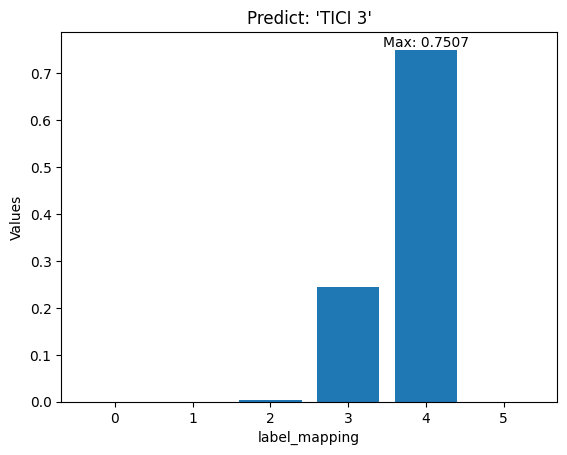

In [ ]:
label_mapping = {
    0: 'TICI 0',
    1: 'TICI 0',
    2: 'TICI 2a',
    3: 'TICI 2b',
    4: 'TICI 3',
    5: 'TICI 3'
}

data = data_loader(dcm_path)
raw_values = model(*data, model_mode=ModelMode.inference, output_mode=OutputMode.last_frame)
values_array = raw_values.numpy()
score = np.argmax(values_array)

plt.bar(range(len(values_array[0])), values_array[0])
plt.text(score, values_array[0, score], f'Max: {values_array[0, score]:.4f}', ha='center', va='bottom')
plt.xlabel('label_mapping')
plt.ylabel('Values')
plt.title(f"Predict: '{label_mapping[score]}'")
plt.show()

torch.Size([1, 22, 2, 3, 224, 224]) tensor([22])


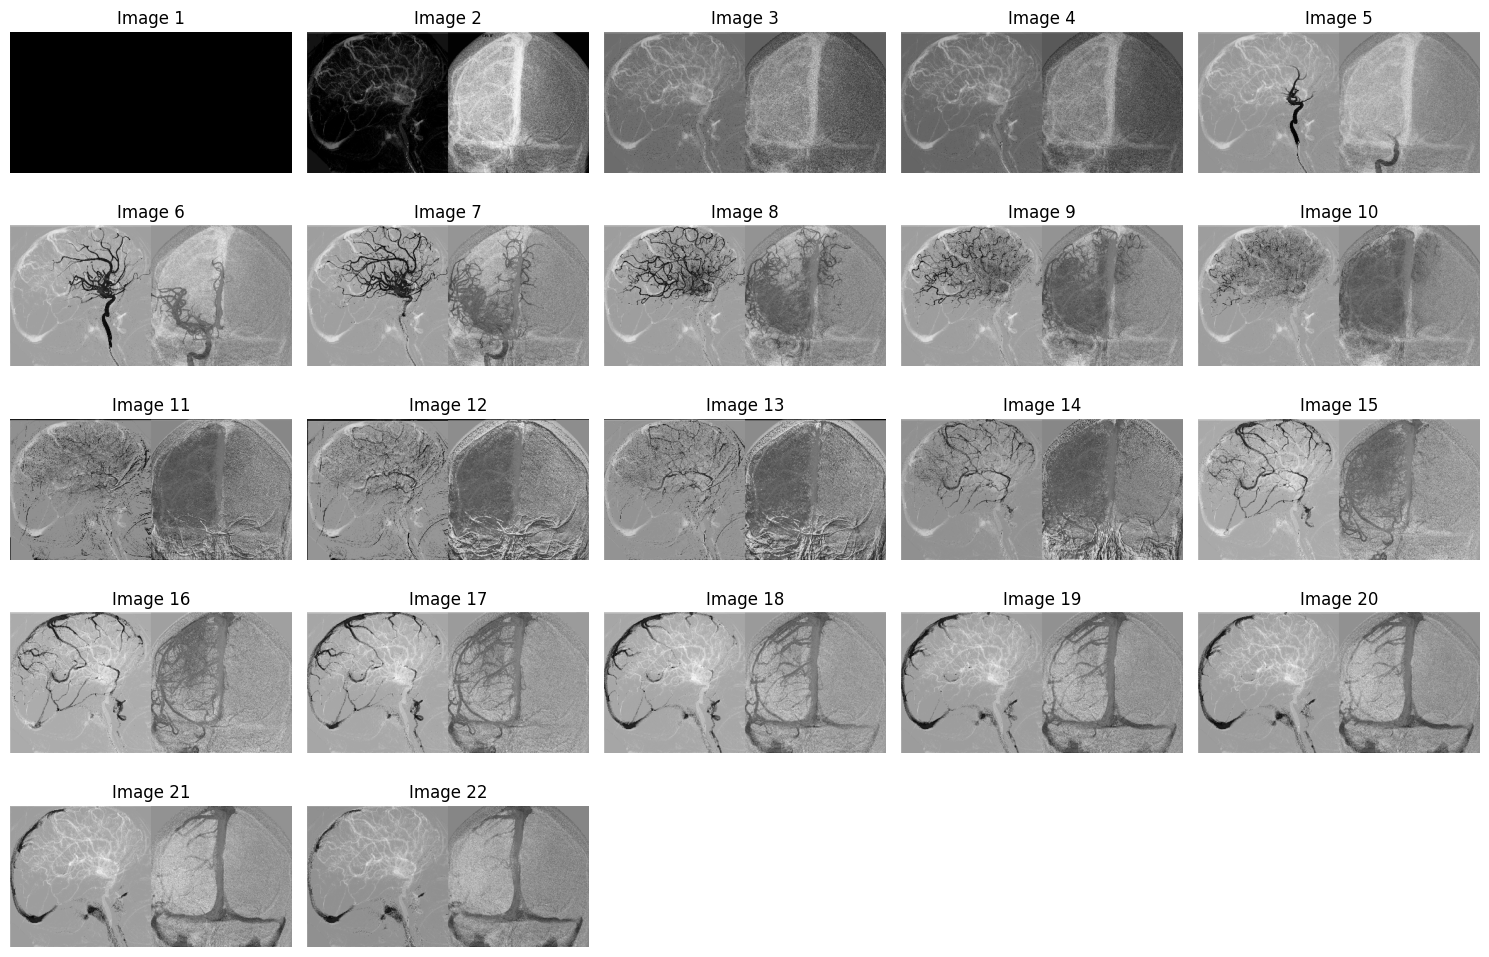

In [ ]:
print(data[0].shape, data[1])
# Reshape data for easier manipulation
plt_A = data[0][0, :, 0, 0, :, :]
plt_B = data[0][0, :, 1, 0, :, :]
plt_img = torch.cat([plt_A, plt_B], dim=2)

# Set the number of images per row
images_per_row = 5

# Calculate the number of rows needed
num_rows = (len(plt_img) - 1) // images_per_row + 1

# Adjust the figure size and spacing
fig, axes = plt.subplots(num_rows, images_per_row, figsize=(15, 10))
plt.subplots_adjust(wspace=0.1, hspace=0.1)

# Flatten the axes array to simplify indexing
axes = axes.flatten()

# Loop through the images and display them
for i in range(len(plt_img)):
    ax = axes[i]
    ax.imshow(plt_img[i], cmap='gray')
    ax.axis('off')  # Turn off axis labels
    ax.set_title(f"Image {i + 1}")

# Remove any empty subplots
for i in range(len(plt_img), len(axes)):
    fig.delaxes(axes[i])

# Show the plot
plt.tight_layout()

# Show the plot
plt.show()


## Clean up temporary files

Warning:
**Ensure that your files are saved elsewhere. This runtime's files will be deleted when this runtime is terminated.**

In [ ]:
!rm *.dcm

Tip: **If you have other DSA data, please return to the [Predict](##Predict) section and upload it without starting from scratch.**